In [6]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import h5py
import time
import platform
from SelectiveKanervaCoding import *
from TOTD import *
from TD import *
from TDLambda import *
from Functions.ExpectedReturn import expectedReturn
from Functions.RLCrossValidation import CrossValidation

if (platform.node() == "Sonny-GamingPC"):
    sys.path.insert(0, "C:/Users/sonny/Box/NeuroRoboticsLab/NERVES Lab/Project Groups/ML Gait/Software/DataProcessing")

from EMGProcessing import *

SKC Testing

In [2]:
SKC = SelectiveKanervaCoding(numInputs = 2, studyID = "Testing")

tic = time.perf_counter()
featureVector = SKC.computeSKC([0.4, 0.5])
toc = time.perf_counter()

print(f"SKC Update completed in {toc - tic:0.4f} seconds")
print(np.sum(featureVector))

Loading prototypes if available...
No prototypes found
Creating prototypes for Testing...
SKC Update completed in 0.0029 seconds
650.0


In [3]:
print(len(featureVector))

15000


In [2]:
for i in range(SKC.K):
    # Plotting all P
    plt.plot(SKC.P[i][0], SKC.P[i][1], marker = 'o', color = 'grey', markersize = 1)

# Plotting Point
    plt.plot(0.4, 0.5, marker = 'o', color = 'black', markersize = 3)

# Plotting C3 
for i in range(SKC.K):
    if featureVector[i] == 1:
        plt.plot(SKC.P[i][0], SKC.P[i][1], marker = 'o', color = 'pink', markersize = 2)

for i in range(SKC.K):
    if featureVector[i + SKC.K] == 1:
        plt.plot(SKC.P[i][0], SKC.P[i][1], marker = 'o', color = 'purple', markersize = 2)

for i in range(SKC.K):
    if featureVector[i + SKC.K*2] == 1:
        plt.plot(SKC.P[i][0], SKC.P[i][1], marker = 'o', color = 'cyan', markersize = 2)

plt.show()

NameError: name 'SKC' is not defined

TOTD Testing

In [7]:
# Importing Data
if platform.node() == "SonnyMacbookPro.local":
    h5pyFile = h5py.File("/Users/sonnyjones/Library/CloudStorage/Box-Box/NeuroRoboticsLab/NERVES Lab/Project Groups/ML Gait/Experimental Data/Mar19Trial(Grange)/Trial 7.h5")
elif platform.node() == "Sonny-GamingPC":
    h5pyFile = h5py.File("C:/Users/sonny/Box/NeuroRoboticsLab/NERVES Lab/Project Groups/ML Gait/Experimental Data/Mar19Trial(Grange)/Trial 7.h5")

In [8]:
# Printing Sensor Attachments
for sensor in h5pyFile.keys():
    try:
        print(f"{sensor} : {h5pyFile[sensor].attrs['Attachment']}")
    except:
        print(f"{sensor} : {h5pyFile[sensor].attrs['Foot']}")

Foot 1 : Left
Foot 2 : Right
Sensor 1 : TAL
Sensor 14 : LK
Sensor 15 : RK
Sensor 2 : TAR
Sensor 3 : LGL
Sensor 4 : LGR
Sensor 5 : VLL
Sensor 6 : VLR
Sensor 7 : BFL
Sensor 8 : BFR


In [9]:
# Printing Sensor Channels
print(h5pyFile['Sensor 1'].keys())

<KeysViewHDF5 ['EMG 1', 'GYRO X', 'GYRO Y', 'GYRO Z']>


In [10]:
# Printing Sample Rates
tal = h5pyFile['Sensor 1/EMG 1']
tar = h5pyFile['Sensor 2/EMG 1']
lgl = h5pyFile['Sensor 3/EMG 1']
lgr = h5pyFile['Sensor 4/EMG 1']

In [11]:
# Sample Rates
sampleRate = h5pyFile['Sensor 1/EMG 1'].attrs['SampleRate']

In [12]:
# Samples Per Iteration
fs = 100
sampPerIter = int(sampleRate * (1/100))

In [13]:
# Combining Data
data = np.stack((tal, tar, lgl, lgr))

In [12]:
data.shape

(4, 114764)

In [14]:
# Downsampling Data
dataSampled = []

for iter in range(int(data.shape[1]/sampPerIter)):
    try:
        dataSampled.append(np.mean(data[:,sampPerIter*iter : sampPerIter*(iter + 1)], axis = 1))
    except:
        dataSampled.append(np.mean(data[:,sampPerIter*iter:], axis = 1))
        break

In [15]:
# Switching to np array
dataSampled = np.array(dataSampled).T

In [37]:
print(np.max(dataSampled[3]))

0.07339428


In [52]:
# Normalizing Data
dataNorm = dataSampled/0.1

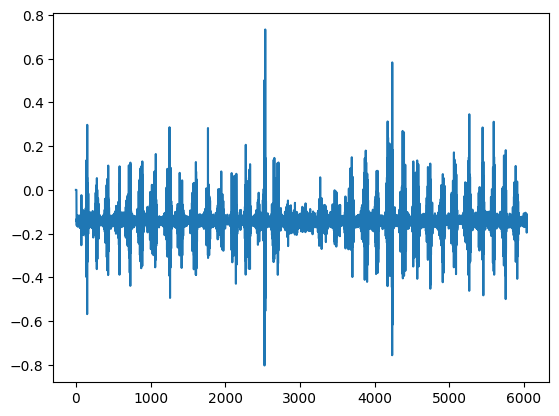

In [53]:
plt.plot(dataNorm[3])

In [55]:
# Enveloping
envelopedData = []

for i in range(dataNorm.shape[0]):
    envelopedData.append(enveloping(dataNorm[i], sampleRate, 50))

In [66]:
envelopedData = np.array(envelopedData).T

In [67]:
envelopedData.shape

(4, 6040)

In [68]:
# Gammas to Test
gammaParams = {'gammas' : np.linspace(0.6, 0.9, 4)}

Loading prototypes if available...
Prototypes loaded successfully
Performing Cross Validation on ['gammas']


Running Cross Validation:   0%|          | 0/4 [00:00<?, ?iteration/s]

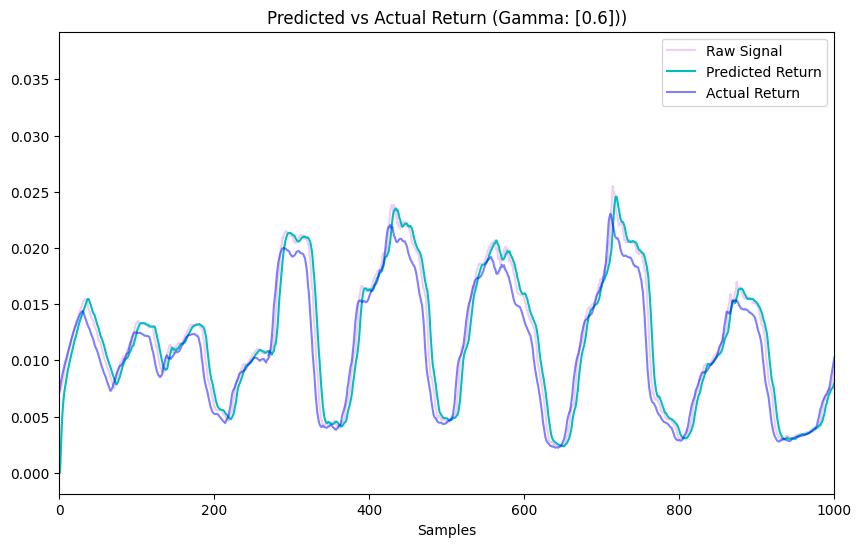

Running Cross Validation:  25%|██▌       | 1/4 [00:32<01:36, 32.09s/iteration]


Params: {'gammas': 0.6}
Lag: -7



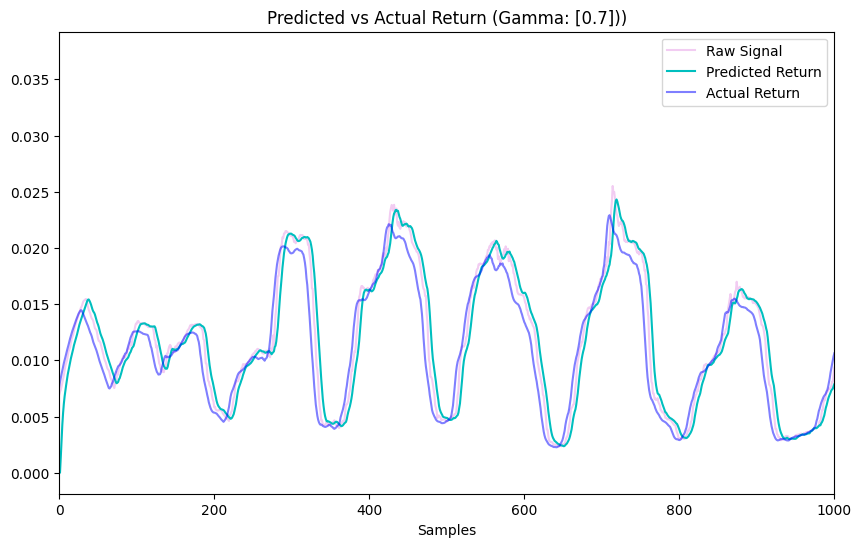

Running Cross Validation:  50%|█████     | 2/4 [01:04<01:04, 32.04s/iteration]


Params: {'gammas': 0.7}
Lag: -8



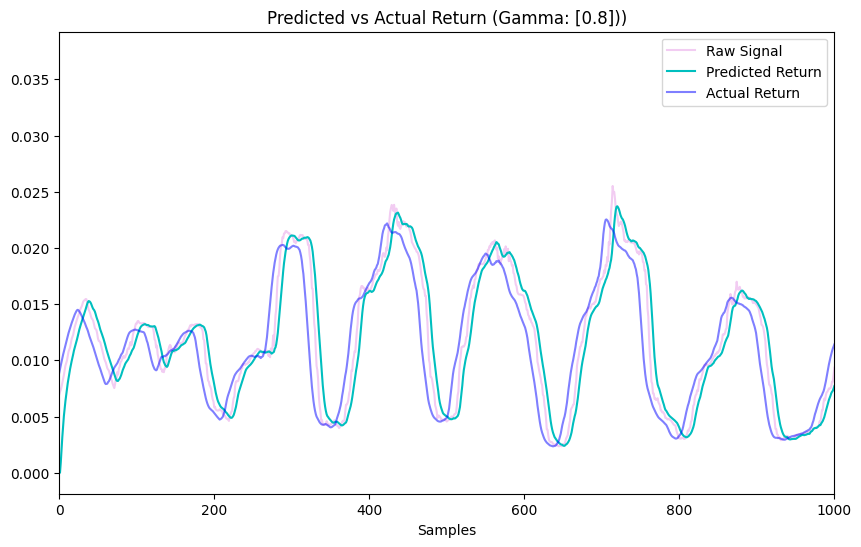

Running Cross Validation:  75%|███████▌  | 3/4 [01:36<00:32, 32.03s/iteration]


Params: {'gammas': 0.8}
Lag: -13



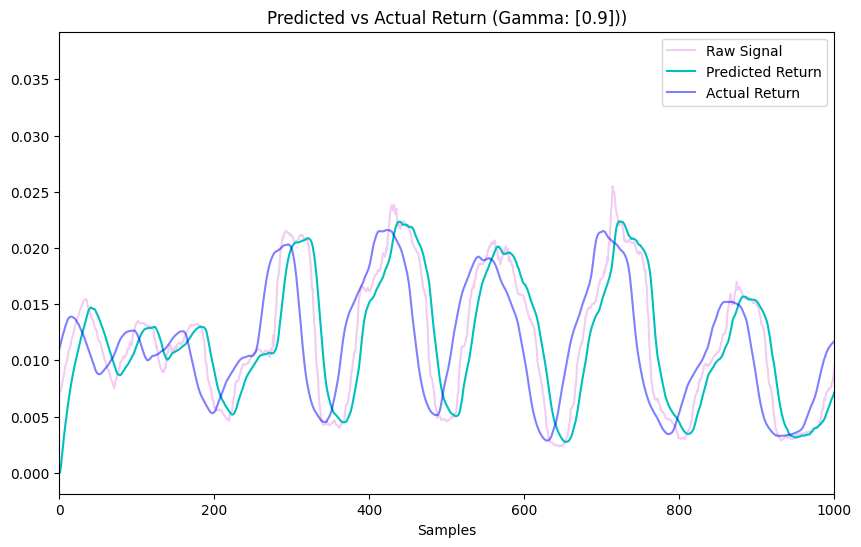

Running Cross Validation: 100%|██████████| 4/4 [02:07<00:00, 31.82s/iteration]


Params: {'gammas': 0.9}
Lag: -23


Best Lag: -7
Best Params: {'gammas': 0.6}


In [70]:
# Importing TOTD Cross Validation
bestLag, bestParams, lagList = CrossValidation(TOTD, envelopedData, envelopedData[0], gammaParams, plot = True, xLimit = [0, 1000])

In [20]:
np.savez("LagListEMG", gammas = np.arange(0.6, 1.0, 0.01), lag = lagList, allow_pickle = False)

Text(0, 0.5, 'Lag (Sampling Periods)')

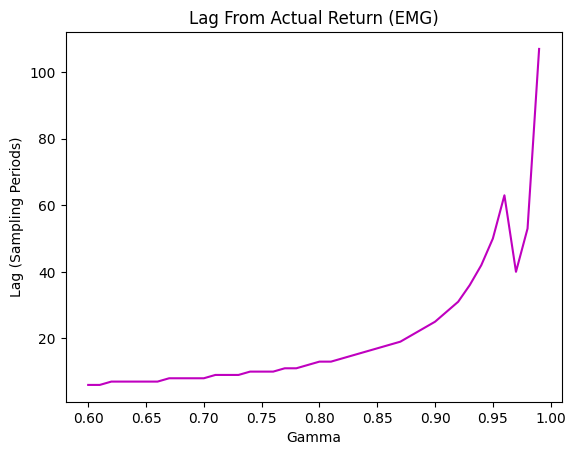

In [14]:
# Plotting Lag with Gamma Values
plt.plot(np.arange(0.6, 1.0, 0.01), lagList, color = 'm')
plt.title("Lag From Actual Return (EMG)")
plt.xlabel("Gamma")
plt.ylabel("Lag (Sampling Periods)")

In [112]:
# Initiated TOTD
totd = TOTD(studyID = 'TOTDTesting', numInputs = envelopedData.shape[0], gammas = [0.9, 0.9, 0.9, 0.9])

Loading prototypes if available...
Prototypes loaded successfully


In [113]:
# Iterating Through Data
predicted = []

# Iterating Through Data
for i in range(envelopedData.shape[1]):
    predictions = totd.update(envelopedData[:,i], envelopedData[0,i])
    predicted.append(predictions)

In [115]:
predicted = np.concatenate(predicted).T

In [116]:
predicted.shape

(4, 6040)

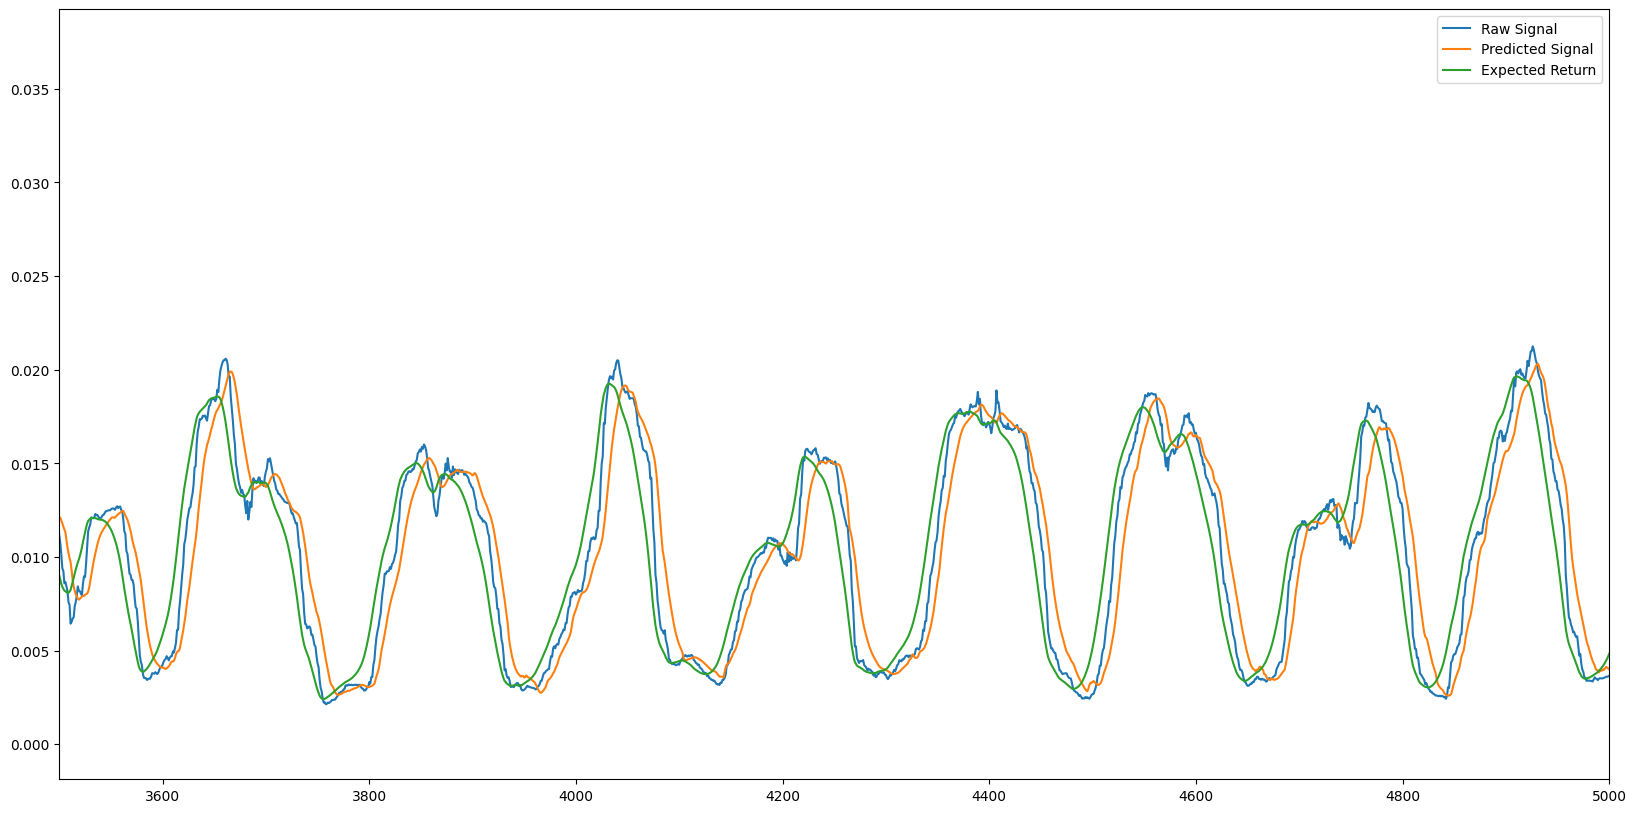

In [117]:
plt.figure(figsize = (20,10))
plt.plot(envelopedData[0,:])
plt.plot(predicted[0,:])
plt.plot(expectedReturn(envelopedData[0,:], 0.9))
plt.legend(['Raw Signal', 'Predicted Signal', 'Expected Return'])
plt.xlim(xmin = 3500, xmax = 5000)
plt.show()

In [33]:
np.save(f"../Algorithms/Predictions/Predictions1.npy", predicted, allow_pickle = False)

In [19]:
processedEMG = predicted[0] - np.mean(predicted[0])

In [95]:
mse = []
highest = []
lowest = []

for i in range(dataNorm.shape[1]):
    errors = dataNorm[0,i] - processedEMG[i]
    
    mse.append(np.mean(errors**2))

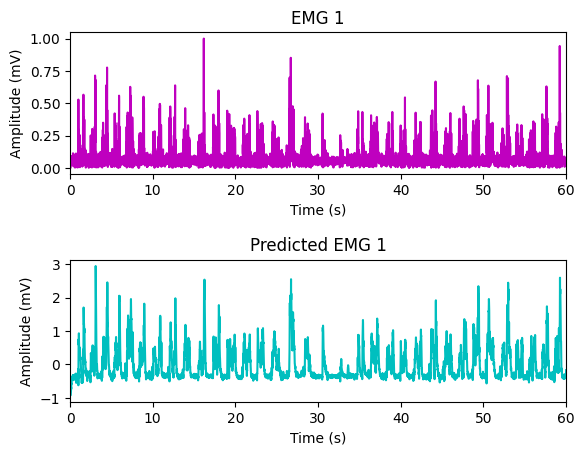

In [20]:
xticks = np.linspace(0, dataNorm.shape[1], dataNorm.shape[1])
xticks = xticks/100

fig, axs = plt.subplots(2)
axs[0].plot(xticks, dataNorm[0], color = 'm')
axs[0].set_title('EMG 1')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude (mV)')
axs[0].set_xlim(xmin = 0, xmax = 60)
axs[1].plot(xticks, processedEMG, color = 'c')
axs[1].set_title('Predicted EMG 1')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude (mV)')
axs[1].set_xlim(xmin = 0, xmax = 60)

plt.subplots_adjust(hspace = 0.6)
plt.show()

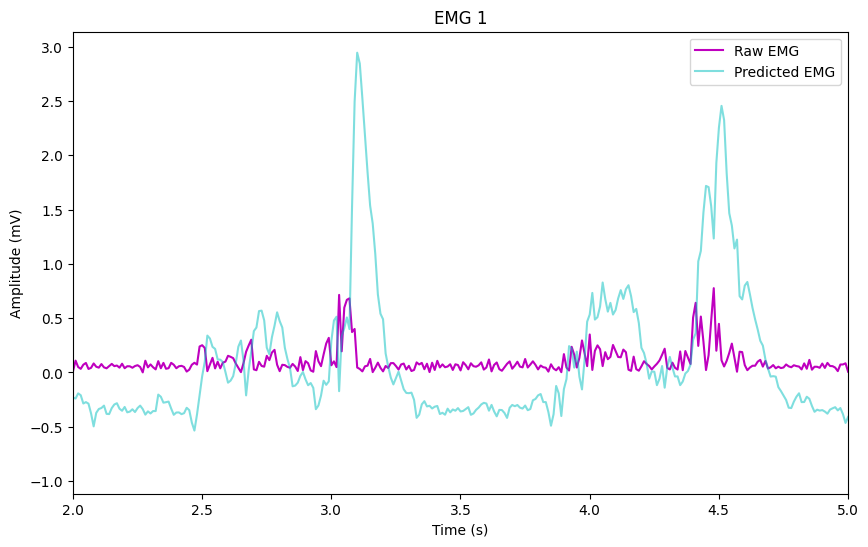

In [22]:
xticks = np.linspace(0, dataNorm.shape[1], dataNorm.shape[1])
xticks = xticks/100

plt.figure(figsize=(10,6))
plt.plot(xticks, dataNorm[0], color = 'm')
plt.title('EMG 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.xlim(xmin = 2, xmax = 5)
plt.plot(xticks, processedEMG, color = 'c', alpha = 0.5)
# axs[1].set_title('Predicted EMG 1')
# axs[1].set_xlabel('Time (s)')
# axs[1].set_ylabel('Amplitude (mV)')
# axs[1].set_xlim(xmin = 0, xmax = 60)

plt.legend(['Raw EMG', 'Predicted EMG'])
plt.show()

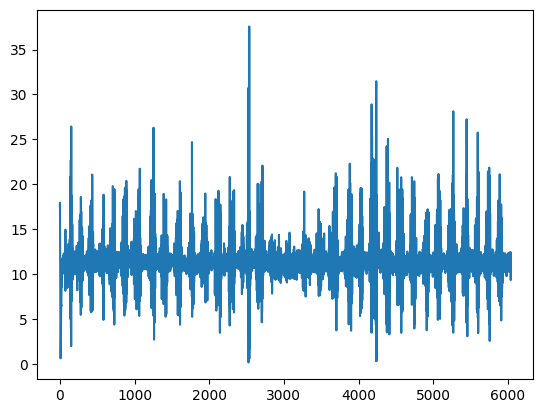

In [57]:
plt.plot(mse)

In [118]:
h5pyFile.close()

In [16]:
a = np.array([1, 2, 3, 4])
b = np.array([1, 2, 3, 4])
c= 10

print(a * b * c)

[ 10  40  90 160]


In [71]:
# Importing Insole Data
if (platform.node() == 'Sonny-GamingPC'):
    insoleData = pd.read_csv("C:/Users/sonny/Box/NeuroRoboticsLab/NERVES Lab/Project Groups/ML Gait/Experimental Data/Mar19Trial(Grange)/Trial4BinnedPressureDf.csv")
elif (platform.node() == 'Purkinje'):
    insoleData = pd.read_csv("C:/Users/Purkinje/Box/NeuroRoboticsLab/NERVES Lab/Project Groups/ML Gait/Experimental Data/Mar19Trial(Grange)/Trial4BinnedPressureDf.csv")

In [72]:
# Applying Normalization
insoleData = insoleData.apply(lambda x: x/17)

In [4]:
# Exploring Dataset
insoleData.describe()

,HalluxL,HalluxR,LateralToesL,LateralToesR,ForefootL,ForefootR,MedialfootL,MedialfootR,RearfootL,RearfootR
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,0.144141,0.153005,0.099555,0.133693,0.272982,0.258638,0.107908,0.123958,0.233994,0.190331
std,0.136257,0.142503,0.070081,0.108086,0.225412,0.221196,0.078933,0.102855,0.231864,0.194852
min,0.026746,0.036914,0.035515,0.023732,0.049641,0.043918,0.034223,0.028685,0.041465,0.041135
25%,0.038500,0.048334,0.046544,0.045680,0.053528,0.049296,0.042683,0.042955,0.053301,0.051866
50%,0.079722,0.086765,0.071691,0.085395,0.214250,0.195953,0.063133,0.069314,0.084543,0.064229
75%,0.228562,0.216556,0.128906,0.203989,0.449509,0.439067,0.171397,0.194501,0.410225,0.326637
max,0.637167,0.704929,0.417187,0.474412,0.766993,0.795045,0.370798,0.417308,0.943829,0.761166


In [73]:
# Transforming to Numpy Array
inputData = np.array(insoleData.values).T

In [13]:
# Checking Shape
inputData.shape

(10, 397)

In [74]:
# Upsampling Data
from scipy.interpolate import interp1d

oldDataIndex = np.linspace(0, inputData.shape[1], inputData.shape[1])
newDataIndex = np.linspace(0, inputData.shape[1], inputData.shape[1] * 10)

# Creating New Array to Hold Data
insoleDataNew = np.zeros((inputData.shape[0], len(newDataIndex)))

# Iterating Over inputData
for index in range(inputData.shape[0]):
    interSignal = interp1d(oldDataIndex, inputData[index,:])(newDataIndex)

    # Cleaning Up Negative Values
    interSignal[interSignal < 0] = 0

    # Setting New Signal
    insoleDataNew[index, :] = interSignal

In [15]:
# Looking at New Data
insoleDataNew.shape

(10, 3970)

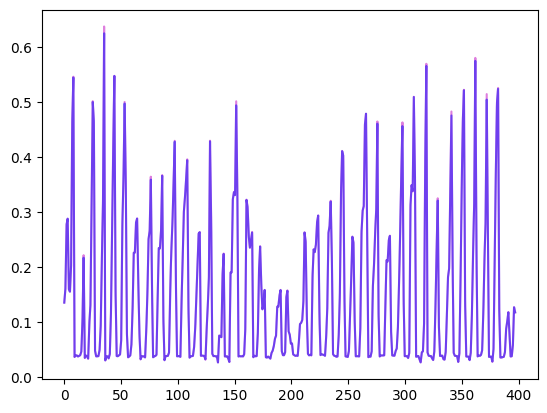

In [75]:
# Plotting Versus Old Data
plt.figure()
plt.plot(oldDataIndex, inputData[0,:], alpha = 0.5, color = 'm')
plt.plot(newDataIndex, insoleDataNew[0,:], alpha = 0.5, color = 'b')
plt.show()

TD

In [34]:
# Initiating TD
td = TD(studyID = 'TDTesting', numInputs = insoleDataNew.shape[0], gammas = [0.9, 0.9])

Loading prototypes if available...
Prototypes loaded successfully


In [35]:
# Iterating Through Data
predicted = []

# Iterating Through Data
for i in range(insoleDataNew.shape[1]):
    predictions = td.update(insoleDataNew[:,i], insoleDataNew[4:6,i])

    if predictions is not None:
        predicted.append(predictions)
    else:
        predicted.append(np.zeros(3))

In [36]:
predicted = np.concatenate(predicted).T

In [37]:
predicted.shape

(2, 3970)

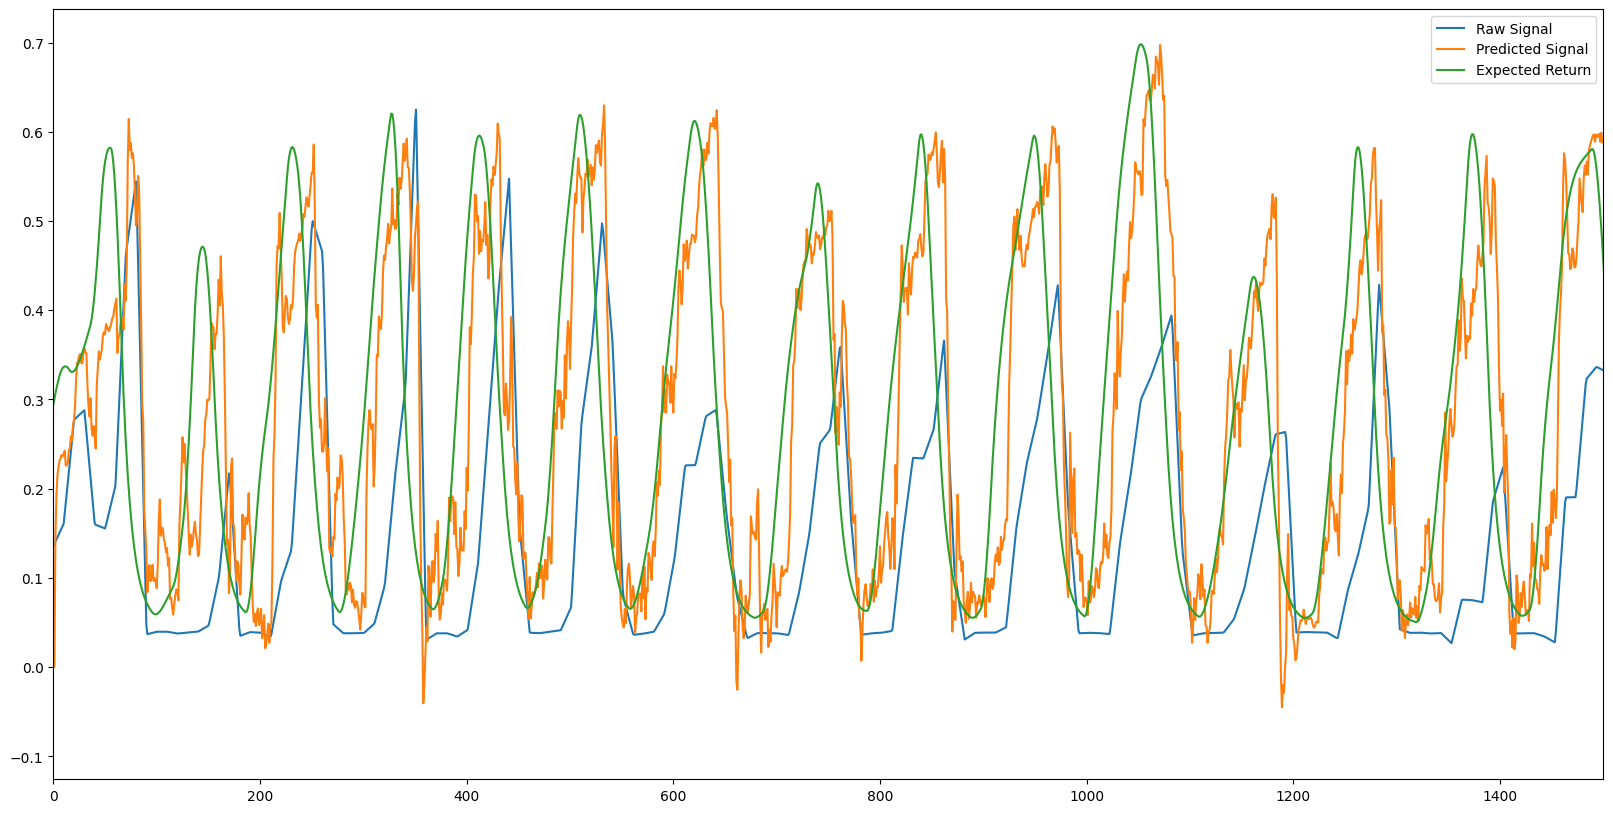

In [40]:
plt.figure(figsize = (20,10))
plt.plot(insoleDataNew[0,:])
plt.plot(predicted[0,:])
plt.plot(expectedReturn(insoleDataNew[4,:], 0.9)*0.1)
plt.legend(['Raw Signal', 'Predicted Signal', 'Expected Return'])
plt.xlim(xmin = 0, xmax = 1500)
plt.show()

TD(Lambda)

In [41]:
# Initaited TD(Lambda)
tdLambda = TDLambda(studyID = 'TDLambdaTesting', numInputs = insoleDataNew.shape[0], gammas = [0.9, 0.9])

Loading prototypes if available...
Prototypes loaded successfully


In [42]:
# Iterating Through Data
predicted1 = []

# Iterating Through Data
for i in range(insoleDataNew.shape[1]):
    predictions = tdLambda.update(insoleDataNew[:,i], insoleDataNew[4:6,i])

    if predictions is not None:
        predicted1.append(predictions)
    else:
        predicted1.append(np.zeros(3))

In [43]:
predicted1 = np.concatenate(predicted1).T

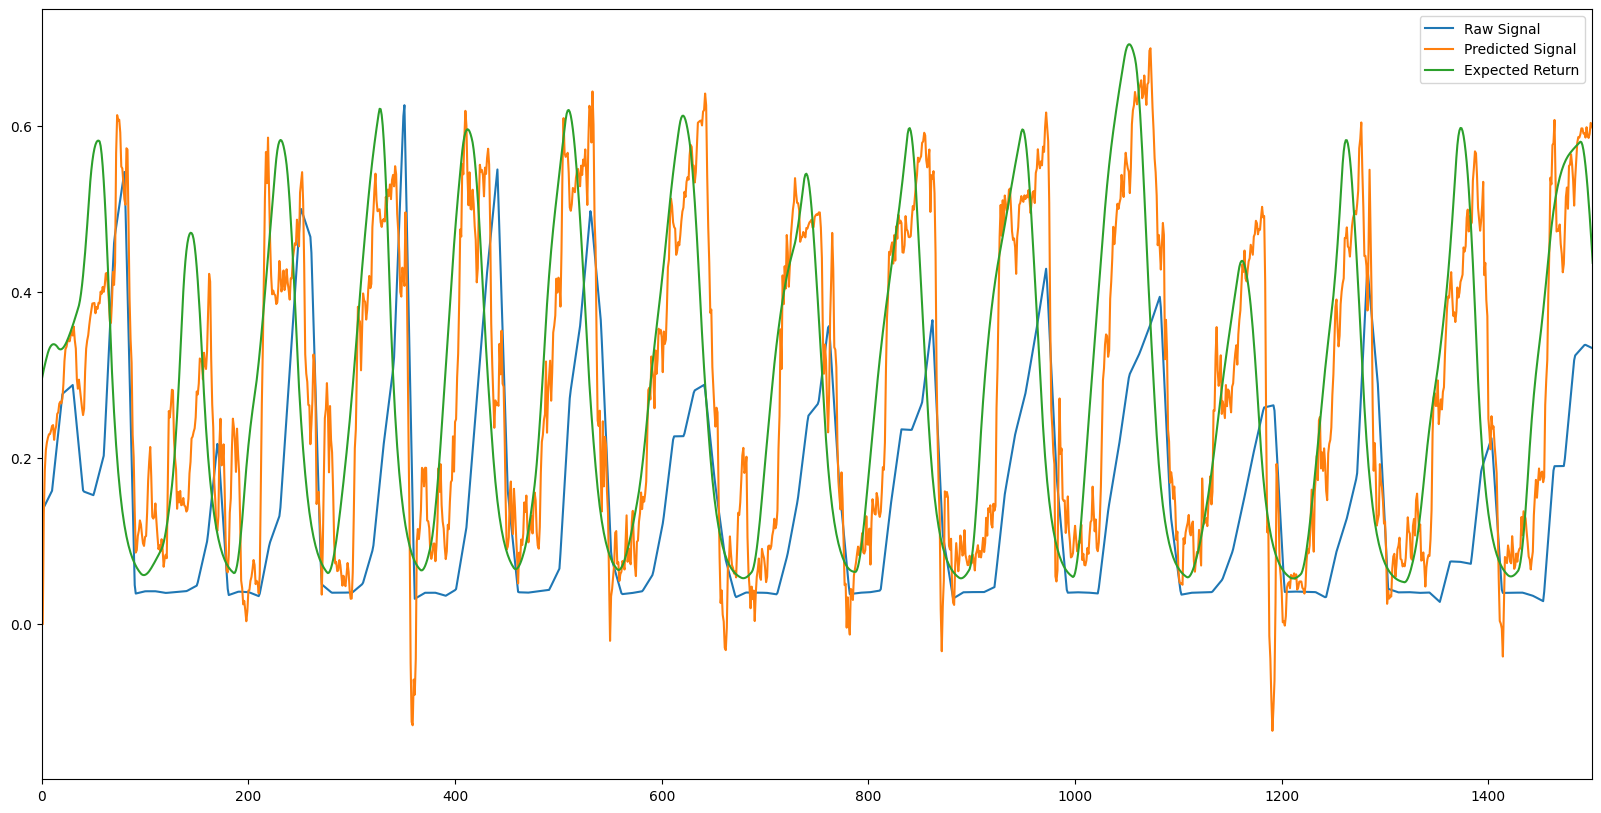

In [44]:
plt.figure(figsize = (20,10))
plt.plot(insoleDataNew[0,:])
plt.plot(predicted1[0,:])
plt.plot(expectedReturn(insoleDataNew[4,:], 0.9)*0.1)
plt.legend(['Raw Signal', 'Predicted Signal', 'Expected Return'])
plt.xlim(xmin = 0, xmax = 1500)
plt.show()

TOTD

In [119]:
# Initiated TOTD
totd = TOTD(studyID = 'TOTDTesting', numInputs = insoleDataNew.shape[0], alpha = 0.0005, gammas = [0.9, 0.9])

Loading prototypes if available...
Prototypes loaded successfully


In [120]:
# Iterating Through Data
predicted2 = []

# Iterating Through Data
for i in range(insoleDataNew.shape[1]):
    predictions = totd.update(insoleDataNew[:,i], insoleDataNew[4:6,i])
    predicted2.append(predictions)

In [122]:
predicted2 = np.concatenate(predicted2).T

In [104]:
predicted2.shape

(2, 3970)

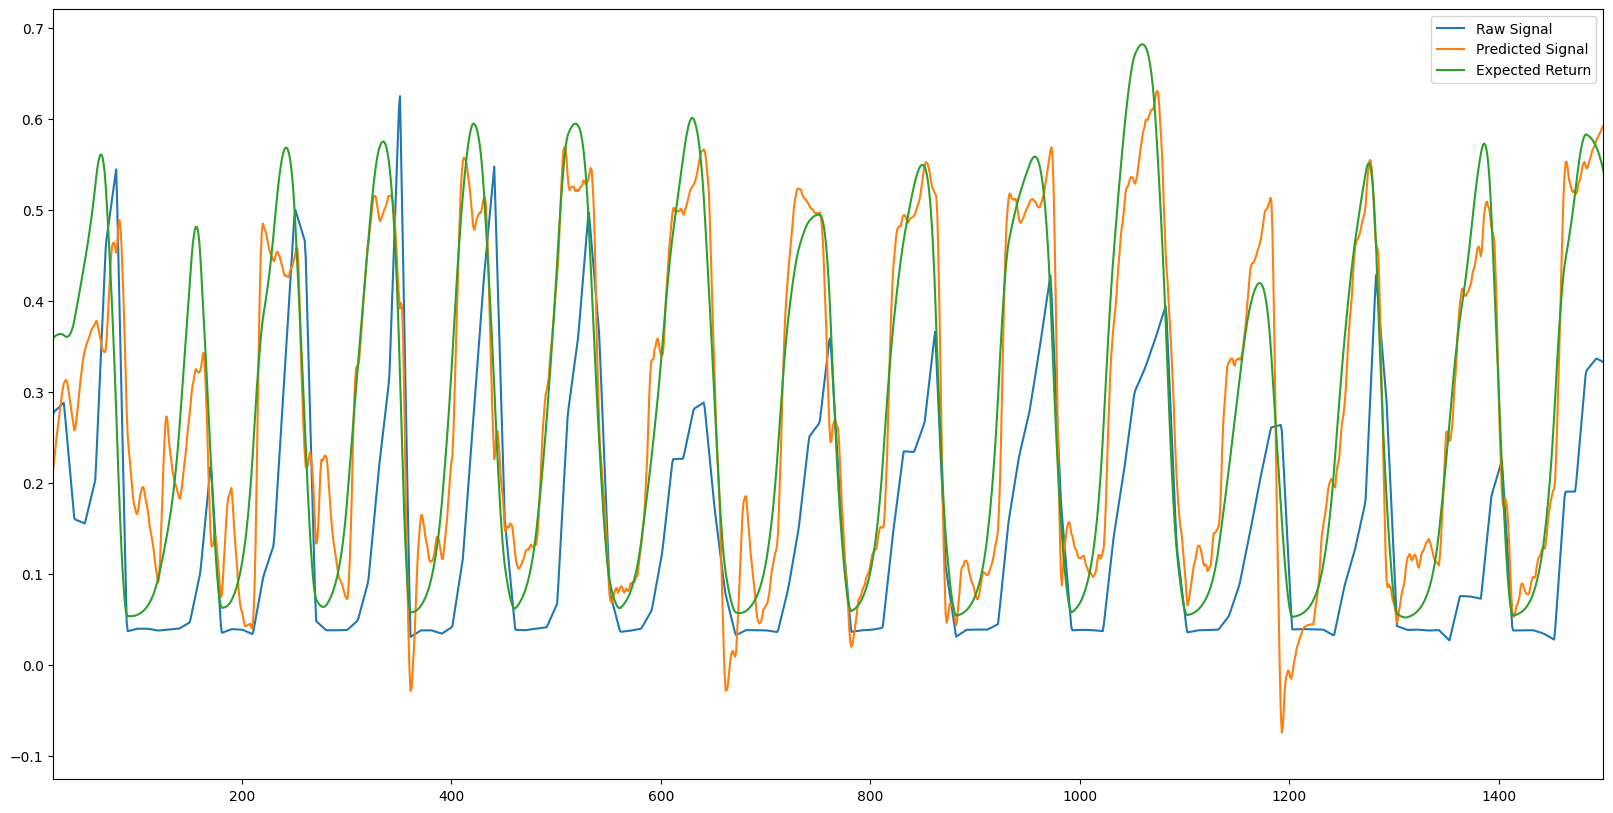

In [123]:
plt.figure(figsize = (20,10))
plt.plot(insoleDataNew[0,:])
plt.plot(predicted2[0,:])
plt.plot(expectedReturn(insoleDataNew[4,:], 0.9))
plt.legend(['Raw Signal', 'Predicted Signal', 'Expected Return'])
plt.xlim(xmin = 20, xmax = 1500)
plt.show()

In [80]:
# Gammas to Test
gammaParams = {'gammas' : np.linspace(0.6, 0.9, 4)}

Loading prototypes if available...
Prototypes loaded successfully
Performing Cross Validation on ['gammas']


Running Cross Validation:   0%|          | 0/4 [00:00<?, ?iteration/s]

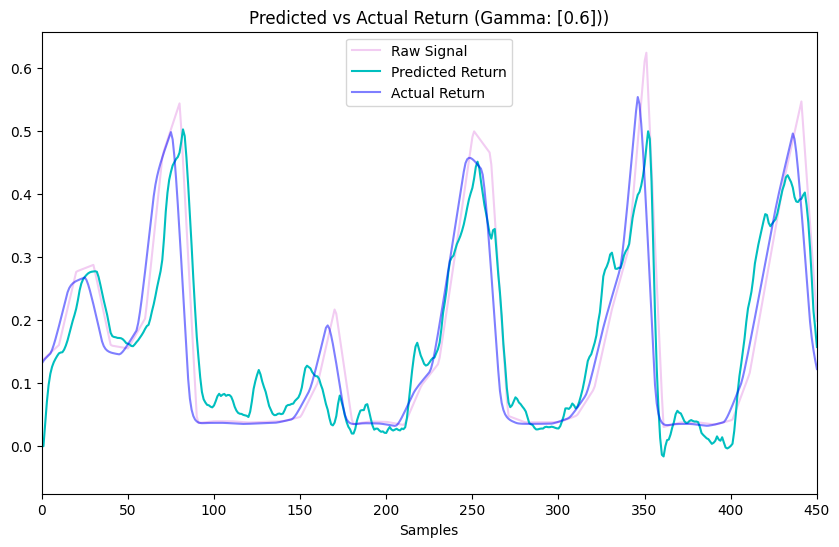

Running Cross Validation:  25%|██▌       | 1/4 [00:27<01:22, 27.48s/iteration]


Params: {'gammas': 0.6}
Lag: -3



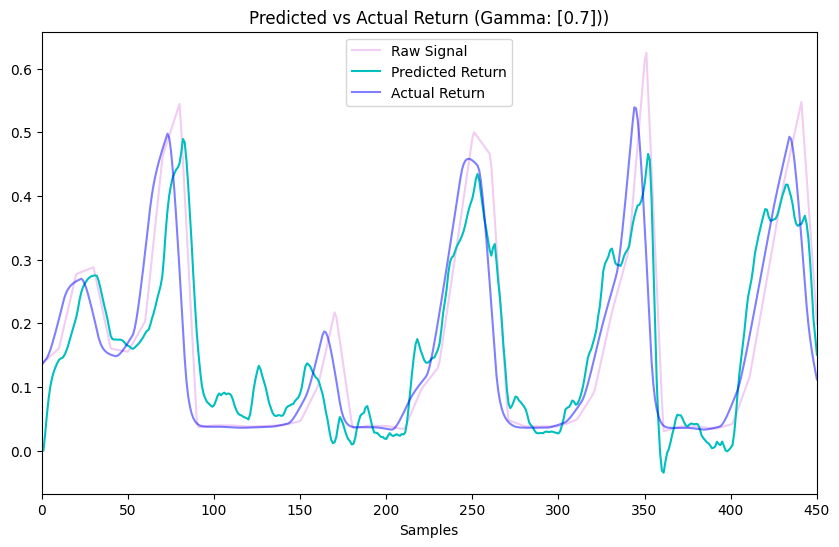

Running Cross Validation:  50%|█████     | 2/4 [00:54<00:54, 27.45s/iteration]


Params: {'gammas': 0.7}
Lag: -4



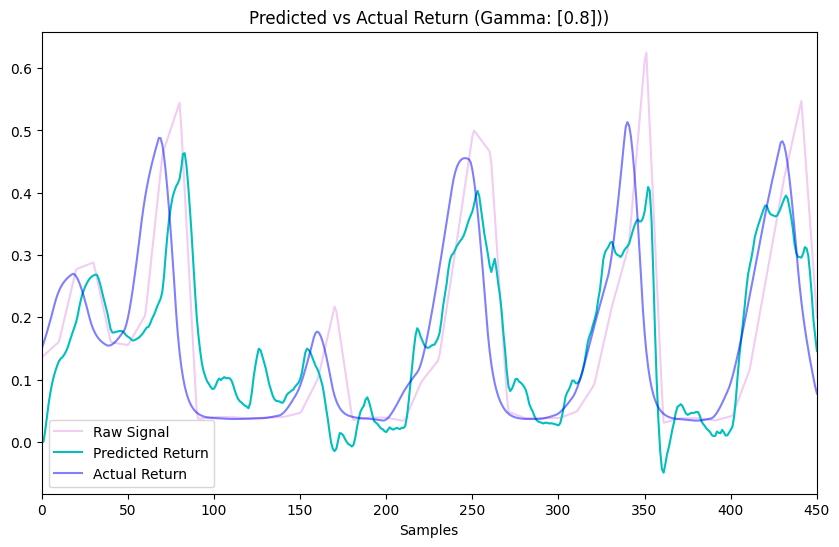

Running Cross Validation:  75%|███████▌  | 3/4 [01:22<00:27, 27.40s/iteration]


Params: {'gammas': 0.8}
Lag: -6



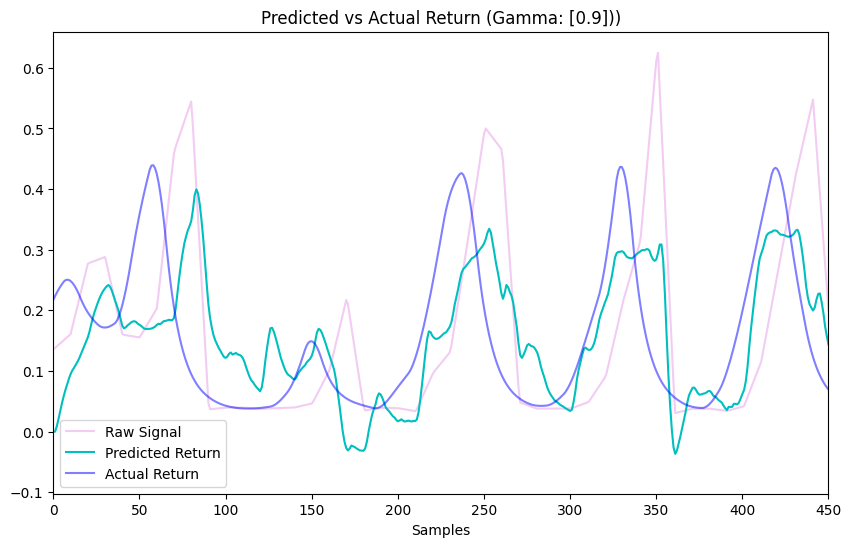

Running Cross Validation: 100%|██████████| 4/4 [01:49<00:00, 27.41s/iteration]


Params: {'gammas': 0.9}
Lag: -12


Best Lag: -3
Best Params: {'gammas': 0.6}


In [81]:
# Importing TOTD Cross Validation
bestLag, bestParams, lagList = CrossValidation(TOTD, insoleDataNew, insoleDataNew[0,:], gammaParams, plot = True, xLimit = [0, 450])

In [6]:
# Initiated TOTD
totd = TOTD(studyID = 'TOTDTesting', numInputs = inputData.shape[1], gammas = [0.9])

Loading prototypes if available...
Prototypes loaded successfully


In [7]:
# Iterating Through Data
predicted = []

# Iterating Through Data
for i in range(inputData.shape[0]):
    predictions = totd.update(inputData[i,:], inputData[i,9])

    if predictions is not None:
        predicted.append(predictions)
    else:
        predicted.append(np.array(0))

In [8]:
# Turning Predictions into Array
predicted = np.array(predicted, dtype="object")

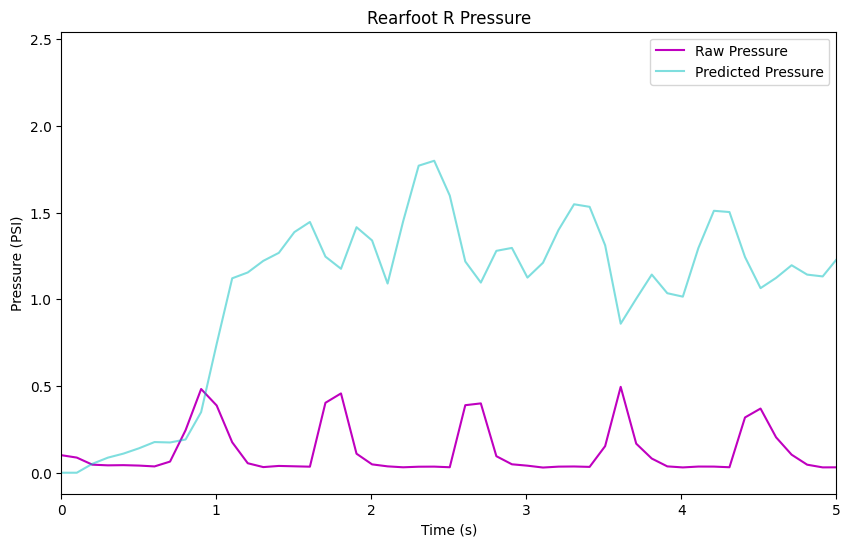

In [10]:
# Plotting
xticks = np.linspace(0, inputData.shape[0], inputData.shape[0])
xticks = xticks/10

plt.figure(figsize=(10,6))
plt.plot(xticks, inputData[:,9], color = 'm')
plt.title('Rearfoot R Pressure')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (PSI)')
plt.xlim(xmin = 0, xmax = 5)
plt.plot(xticks, predicted, color = 'c', alpha = 0.5)
# axs[1].set_title('Predicted EMG 1')
# axs[1].set_xlabel('Time (s)')
# axs[1].set_ylabel('Amplitude (mV)')
# axs[1].set_xlim(xmin = 0, xmax = 60)

plt.legend(['Raw Pressure', 'Predicted Pressure'])
plt.show()

In [9]:
# Calulating Rearfoot R Expected Return Over 5x Tau: where Tau = 1/ (1- gamma)
RearfootRReturn = expectedReturn(inputData[:,9], 0.9)

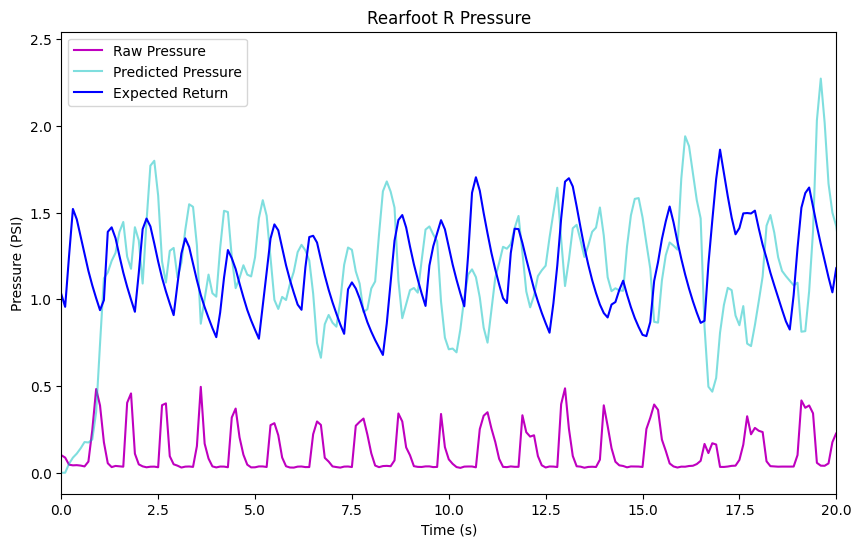

In [14]:
# Plotting
# Checking Return
returnValues = int(inputData.shape[0])

xticks = np.arange(0, returnValues)
xticks = xticks/10

plt.figure(figsize=(10,6))
plt.plot(xticks, inputData[:returnValues,9], color = 'm')
plt.title('Rearfoot R Pressure')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (PSI)')
plt.xlim(xmin = 0, xmax = 20)
plt.plot(xticks, predicted[:returnValues], color = 'c', alpha = 0.5)
plt.plot(xticks, RearfootRReturn, color = 'b')
# axs[1].set_title('Predicted EMG 1')
# axs[1].set_xlabel('Time (s)')
# axs[1].set_ylabel('Amplitude (mV)')
# axs[1].set_xlim(xmin = 0, xmax = 60)

plt.legend(['Raw Pressure', 'Predicted Pressure', 'Expected Return'])
plt.show()

In [15]:
crossCor = scipy.signal.correlate(predicted, RearfootRReturn)
lags = scipy.signal.correlation_lags(len(predicted), len(RearfootRReturn))
lag = lags[np.argmax(crossCor)]

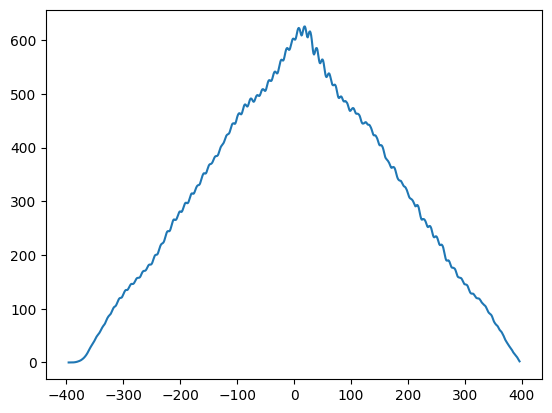

In [19]:
plt.plot(lags, crossCor)

In [8]:
array = np.array([[1, 2, 3, 4, 5]])

print(array.shape)

(1, 5)
